In [3]:
import xarray as xr
import copernicusmarine
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Set parameters
data_request = {
   "dataset_glorys12v1" : "cmems_mod_glo_phy_my_0.083deg_P1D-m",
   "longitude" : [-30, -27.4], 
   "latitude" : [-30,-27.4],
   "time" : ["1993-01-01", "2021-06-30"],
   "variables" : ["zos"]
}

# Load xarray dataset
dat = copernicusmarine.open_dataset(
    dataset_id = data_request["dataset_glorys12v1"],
    minimum_longitude = data_request["longitude"][0],
    maximum_longitude = data_request["longitude"][1],
    minimum_latitude = data_request["latitude"][0],
    maximum_latitude = data_request["latitude"][1],
    start_datetime = data_request["time"][0],
    end_datetime = data_request["time"][1],
    variables = data_request["variables"]
)

Fetching catalog: 100%|██████████| 3/3 [00:21<00:00,  7.32s/it]
INFO - 2024-08-28T19:47:49Z - Dataset version was not specified, the latest one was selected: "202311"
INFO - 2024-08-28T19:47:49Z - Dataset part was not specified, the first one was selected: "default"
INFO - 2024-08-28T19:47:55Z - Service was not specified, the default one was selected: "arco-time-series"


username:

  pwalfir


password:

  ········


In [5]:
dat

<xarray.Dataset> Size: 43MB
Dimensions:    (time: 10408, latitude: 32, longitude: 32)
Coordinates:
  * latitude   (latitude) float32 128B -30.0 -29.92 -29.83 ... -27.5 -27.42
  * longitude  (longitude) float32 128B -30.0 -29.92 -29.83 ... -27.5 -27.42
  * time       (time) datetime64[ns] 83kB 1993-01-01 1993-01-02 ... 2021-06-30
Data variables:
    zos        (time, latitude, longitude) float32 43MB ...
Attributes: (12/24)
    Conventions:        CF-1.4
    bulletin_date:      2021-07-07 00:00:00
    bulletin_type:      operational
    comment:            CMEMS product
    domain_name:        GL12
    easting:            longitude
    ...                 ...
    northing:           latitude
    references:         http://www.mercator-ocean.fr
    source:             MERCATOR GLORYS12V1
    title:              daily mean fields from Global Ocean Physics Analysis ...
    z_max:              5727.9169921875
    z_min:              0.49402499198913574

In [8]:
dat_dow = dat.coarsen(latitude=8,longitude=8,boundary='trim').mean()

In [12]:
pwd

'/home/jovyan/ohw24_proj_upSSH_us/contributor_folders/team_member_1'

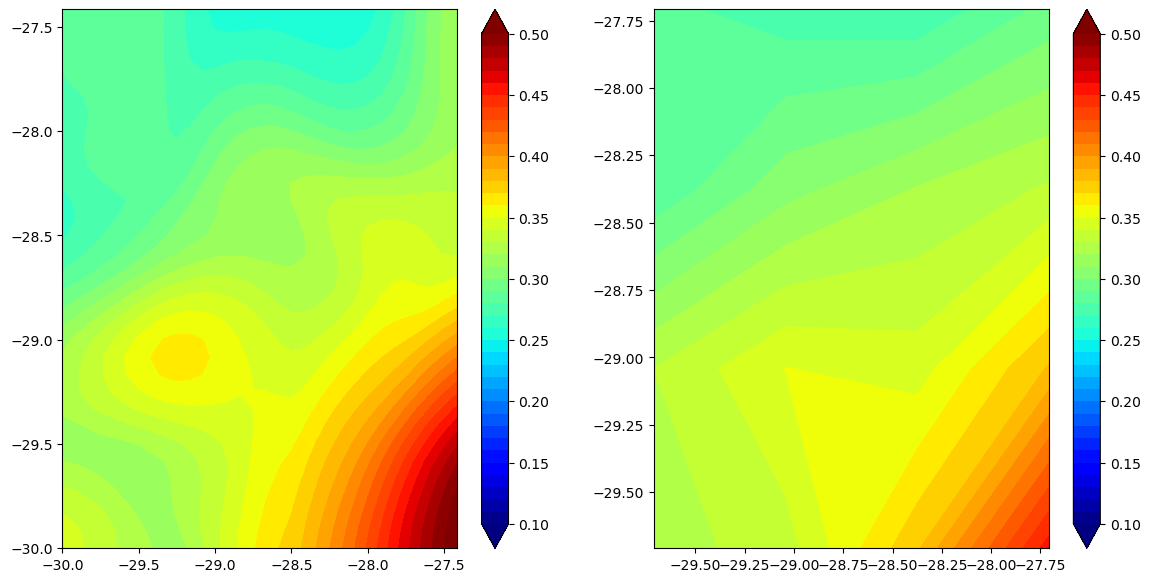

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))  # Create a figure with 2 subplots side by side

# First contour plot
contour1 = ax1.contourf(dat.longitude, dat.latitude, dat.zos.isel(time=-1), 
                        np.linspace(0.1, .5, 41), cmap='jet', extend='both')
fig.colorbar(contour1, ax=ax1)  # Add colorbar to the first plot

contour2 = ax2.contourf(dat_dow.longitude, dat_dow.latitude, dat_dow.zos.isel(time=-1), 
                        np.linspace(0.1, .5, 41), cmap='jet', extend='both')
fig.colorbar(contour2, ax=ax2)  # Add colorbar to the second plot


In [148]:
dat.zos.shape,dat_dow.zos.shape

((10408, 32, 32), (10408, 4, 4))

In [149]:
dats = dat.zos.expand_dims({'NewDim':1}).transpose("time", "latitude", "longitude","NewDim")
dats_dow = dat_dow.zos.expand_dims({'NewDim':1}).transpose("time", "latitude", "longitude","NewDim")

In [150]:
from sklearn.model_selection import train_test_split

In [151]:
X_train, X_test, y_train, y_test = dats_dow[:-365], dats_dow[-365:], dats[:-365], dats[-365:]

In [152]:
X_train.shape,y_train.shape

((10043, 4, 4, 1), (10043, 32, 32, 1))

In [153]:
X_test.shape,y_test.shape

((10043, 4, 4, 1), (10043, 32, 32, 1))

In [154]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((X_train.astype('float32'), y_train.astype('float32')))
dataset = dataset.shuffle(buffer_size=256).batch(batch_size)


In [155]:
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Concatenate, Conv2D, Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import GlobalAveragePooling2D, Input, UpSampling2D


def create_generator(
    block_widths=(128,64,32),
    input_shape=(4,4,1),
    noise_shape=(4,4,8)
):
    # inputs (concatenated)
    input_lr = Input(shape=input_shape)
    input_noise = Input(shape=noise_shape)
    x = Concatenate()([input_lr, input_noise])

    x = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same'
    )(x)
    x = LeakyReLU(0.2)(x)
    # upsampling stages
    for width in block_widths:
        x = UpSampling2D(interpolation='bilinear')(x)
        x = Conv2D(
            width, kernel_size=(3,3), padding='same'
        )(x)
        x = LeakyReLU(0.2)(x)

    # final projection to output space
    output = Conv2D(1, kernel_size=(1,1))(x)

    return Model(inputs=[input_lr, input_noise], outputs=output)


def create_discriminator(
    block_widths=(32,64,128),
    input_shape_hr=(32,32,1),
    input_shape_lr=(4,4,1),
    postproc_convs=2,
    output_activation='linear' # 'linear' when using 'from_logits' in loss
):
    # inputs
    input_hr = Input(shape=input_shape_hr)
    input_lr = Input(shape=input_shape_lr)

    # Convolution steps for both HR and LR inputs
    x_hr = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same', activation='relu'
    )(input_hr)
    x_hr = LeakyReLU(0.2)(x_hr)
    x_lr = Conv2D(
        block_widths[0], kernel_size=(3,3), padding='same', activation='relu'
    )(input_lr)
    x_lr = LeakyReLU(0.2)(x_lr)
    for width in block_widths:
        x_hr = Conv2D( # downsample HR samples on each loop
            width, kernel_size=(3,3), padding='same', strides=2,
        )(x_hr)
        x_hr = LeakyReLU(0.2)(x_hr)
        x_lr = Conv2D(
            width, kernel_size=(3,3), padding='same'
        )(x_lr)
        x_lr = LeakyReLU(0.2)(x_lr)

    # Concatenate HR and LR branches and do some joint processing
    x = Concatenate()([x_hr, x_lr])
    for _ in range(postproc_convs):
        x = Conv2D(block_widths[-1], kernel_size=(3,3), padding='same')(x)
        x = LeakyReLU(0.2)(x)

    # Pool to get outputs
    x = GlobalAveragePooling2D()(x)
    output = Dense(1, activation=output_activation)(x)

    return Model(inputs=[input_lr, input_hr], outputs=output)


generator = create_generator()
discriminator = create_discriminator()


In [156]:
generator.summary()
discriminator.summary()

Model: "functional_34"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_102     │ (None, 4, 4, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_103     │ (None, 4, 4, 8)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_51      │ (None, 4, 4, 9)   │          0 │ input_layer_102[… │
│ (Concatenate)       │                   │            │ input_layer_103[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_343 (Conv2D) │ (None, 4, 4, 128) │     10,496 │ concatenate_51[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_318     │ (None, 4, 4, 128) │          0 │ conv2d_343[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_75    │ (None, 8, 8, 128) │          0 │ leaky_re_lu_318[… │
│ (UpSampling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_344 (Conv2D) │ (None, 8, 8, 128) │    147,584 │ up_sampling2d_75… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_319     │ (None, 8, 8, 128) │          0 │ conv2d_344[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_76    │ (None, 16, 16,    │          0 │ leaky_re_lu_319[… │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_345 (Conv2D) │ (None, 16, 16,    │     73,792 │ up_sampling2d_76… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_320     │ (None, 16, 16,    │          0 │ conv2d_345[0][0]  │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_77    │ (None, 32, 32,    │          0 │ leaky_re_lu_320[… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_346 (Conv2D) │ (None, 32, 32,    │     18,464 │ up_sampling2d_77… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_321     │ (None, 32, 32,    │          0 │ conv2d_346[0][0]  │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_347 (Conv2D) │ (None, 32, 32, 1) │         33 │ leaky_re_lu_321[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 250,369 (978.00 KB)

 Trainable params: 250,369 (978.00 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_35"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_104     │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_105     │ (None, 4, 4, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_348 (Conv2D) │ (None, 32, 32,    │        320 │ input_layer_104[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_349 (Conv2D) │ (None, 4, 4, 32)  │        320 │ input_layer_105[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_322     │ (None, 32, 32,    │          0 │ conv2d_348[0][0]  │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_323     │ (None, 4, 4, 32)  │          0 │ conv2d_349[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_350 (Conv2D) │ (None, 16, 16,    │      9,248 │ leaky_re_lu_322[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_351 (Conv2D) │ (None, 4, 4, 32)  │      9,248 │ leaky_re_lu_323[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_324     │ (None, 16, 16,    │          0 │ conv2d_350[0][0]  │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_325     │ (None, 4, 4, 32)  │          0 │ conv2d_351[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_352 (Conv2D) │ (None, 8, 8, 64)  │     18,496 │ leaky_re_lu_324[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_353 (Conv2D) │ (None, 4, 4, 64)  │     18,496 │ leaky_re_lu_325[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_326     │ (None, 8, 8, 64)  │          0 │ conv2d_352[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_327     │ (None, 4, 4, 64)  │          0 │ conv2d_353[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_354 (Conv2D) │ (None, 4, 4, 128) │     73,856 │ leaky_re_lu_326[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_355 (Conv2D) │ (None, 4, 4, 128) │     73,856 │ leaky_re_lu_327[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_328     │ (None, 4, 4, 128) │          0 │ conv2d_354[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_329     │ (None, 4, 4, 128) │          0 │ conv2d_355[0][0]  │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_52      │ (None, 4, 4, 256) │          0 │ leaky_re_lu_328[

 Total params: 646,593 (2.47 MB)

 Trainable params: 646,593 (2.47 MB)

 Non-trainable params: 0 (0.00 B)

In [157]:
# Adapted from https://keras.io/examples/generative/conditional_gan/

class DownscalingGAN(Model):
    def __init__(self, discriminator, generator, noise_shape=(4,4,8)):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.noise_shape = noise_shape
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")
        self.step_number = tf.Variable(0)

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        (samples_lr, samples_hr) = data

        # Sample noise for the generator.
        batch_size = tf.shape(samples_hr)[0]
        noise = tf.random.normal(
            shape=(batch_size,)+self.noise_shape
        )

        def train_discriminator():
            # Generate fake samples.
            samples_gen = self.generator([samples_lr, noise])

            # Combine them with real images.
            combined_samples_hr = tf.concat([samples_gen, samples_hr], axis=0)
            combined_samples_lr = tf.concat([samples_lr, samples_lr], axis=0)

            # Assemble labels discriminating real from fake images.
            labels = tf.concat(
                [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
            )

            # Train the discriminator.
            with tf.GradientTape() as tape:
                predictions = self.discriminator(
                    [combined_samples_lr, combined_samples_hr]
                )
                d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )

            # Monitor loss.
            self.disc_loss_tracker.update_state(d_loss)

        def train_generator():
            # Create labels that say "all real images".
            misleading_labels = tf.zeros((batch_size, 1))

            # Train the generator (note that we should *not* update the weights
            # of the discriminator)!
            with tf.GradientTape() as tape:
                samples_gen = self.generator([samples_lr, noise])
                predictions = self.discriminator([samples_lr, samples_gen])
                g_loss = self.loss_fn(misleading_labels, predictions)
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(
                zip(grads, self.generator.trainable_weights)
            )

            # Monitor loss.
            self.gen_loss_tracker.update_state(g_loss)
        
        # If we trained the generator now, train the discriminator next
        # or vice versa.
        
        tf.cond(
            self.step_number % 2 == 0,
            train_discriminator,
            train_generator
        )        
        self.step_number.assign(self.step_number+1)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

gan = DownscalingGAN(discriminator, generator)

gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    g_optimizer=keras.optimizers.Adam(learning_rate=3e-4),
    loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
)



In [158]:
dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 4, 4, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None))>

In [159]:
gan.fit(dataset, epochs=30)

Epoch 1/30


2024-08-27 20:46:37.266052: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:966] remapper failed: INVALID_ARGUMENT: Mutation::Apply error: fanout 'StatefulPartitionedCall/cond/else/_111/gradient_tape/cond/functional_34_1/leaky_re_lu_320_1/LeakyRelu/LeakyReluGrad' exist for missing node 'StatefulPartitionedCall/cond/else/_111/cond/functional_34_1/conv2d_345_1/add'.


157/157 ━━━━━━━━━━━━━━━━━━━━ 35s 183ms/step - d_loss: 0.6917 - g_loss: 0.7393
Epoch 2/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - d_loss: 0.6856 - g_loss: 0.7500
Epoch 3/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - d_loss: 0.6873 - g_loss: 0.7684
Epoch 4/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - d_loss: 0.7031 - g_loss: 0.6535
Epoch 5/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 41s 181ms/step - d_loss: 0.6933 - g_loss: 0.8462
Epoch 6/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - d_loss: 0.6677 - g_loss: 0.7087
Epoch 7/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - d_loss: 0.6940 - g_loss: 0.6665
Epoch 8/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - d_loss: 0.6898 - g_loss: 0.6646
Epoch 9/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 29s 182ms/step - d_loss: 0.6920 - g_loss: 0.6919
Epoch 10/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 181ms/step - d_loss: 0.6881 - g_loss: 0.6677
Epoch 11/30
157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 179ms/step - d_loss: 0.7021 - g_loss: 0.8275
Epoch 12/30
157/157 ━━━━━━━━━━

In [161]:
from matplotlib import colors, gridspec, pyplot as plt

def plot_precip(ax, logR):
    ax.imshow(R, norm=colors.LogNorm(0.1,100,clip=True))
    ax.tick_params(left=False, bottom=False,
        labelleft=False, labelbottom=False)

def plot_samples(samples, labels=None):
    """ Plot a grid with many images.
    """
    N_variables = len(samples)
    N_samples = len(samples[0])
    fig = plt.figure(figsize=(N_samples*1.5, N_variables*1.5))
    gs = gridspec.GridSpec(N_variables, N_samples, hspace=0.02, wspace=0.02)

    for (i,variable) in enumerate(samples):
        for (j,sample) in enumerate(variable):
            ax = fig.add_subplot(gs[i,j])
            plot_precip(ax, sample)
            if (j == 0) and (labels is not None):
                ax.set_ylabel(labels[i])

    fig.show()

NameError: name 'R' is not defined

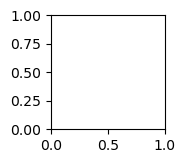

In [164]:
rng = np.random.RandomState(seed=15)
num_samples = 8

# Selection of interesting samples from the test set
indices = [2,5,14,16,17,19,28,37]

# Uncomment to use a random selection (change seed for a different selection):
# indices = rng.choice(samples.shape[0], num_samples, replace=False)

noise = rng.randn(num_samples, 4, 4, 8)
samples_gen_1 = generator.predict_on_batch(
    [X_test[indices,...], noise]
)
noise = rng.randn(num_samples, 4, 4, 8)
samples_gen_2 = generator.predict_on_batch(
    [X_test[indices,...], noise]
)
plot_samples(
    [
        X_test[indices,...], y_test[indices,...], 
        samples_gen_1, samples_gen_2    
    ],
    labels=["LR samples", "HR samples", "Gen. samples 1", "Gen. samples 2"]
)
